##Лапина Анастасия, группа 9383
#**Практическая работа №1: Изучение возможности библиотек Python для решения задач цифровой обработки сигналов**



**Вариант 8**



#**1. Загрузка аудио сигнала и построение огибающей**

Имеется сигнал ${x(i), i = 0,1, . . . ,N - 1}$. Хотим построить огибающую ${y(j), j = 0,1, . . . ,n - 1}$. Пусть ${m = \left [ \frac{N}{n}  \right ]}$ — число точек в интервале усреднения. Тогда ${y(j) = \frac {1}{m} \sum_{k=mj}^{k=mj + m -1} \left | x(k) \right | }$

Использована библиотека librosa для чтения аудио.

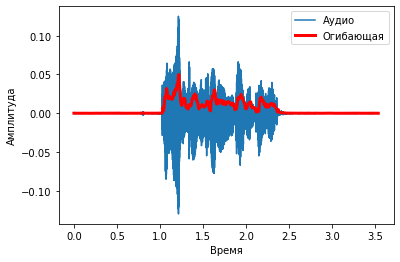

In [2]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

audio_data = '/content/03-01-05-01-02-01-08_A8.wav'
x, sf = librosa.load(audio_data)

n = 500
N = len(x)
time = np.linspace(0, N / sf, N)
m = int(N / n)
line_1 = np.linspace(0, N / sf, n)
y = []

# считаем значения для огибающей
for j in range(n):
  sum = 0
  for z in range(m * j, m * j + m - 1):
    sum = sum + abs(x[z])
  y.append(sum / m)
  

plt.plot(time, x, label="Аудио")
plt.plot(line_1, y, label="Огибающая", linewidth=3, color = "red")
plt.xlabel("Время")
plt.ylabel("Амплитуда")
plt.legend()
plt.show()



## **2. Фильтрация сигнала**
Были выбраны фильтры верхних и нижних частот.
Пусть  Fd  - частота дискретизации, частота среза -  Fs , порядок фильтра -  m . Тогда вычисляем  ${wn=2{\frac{Fs}{Fd}}}$

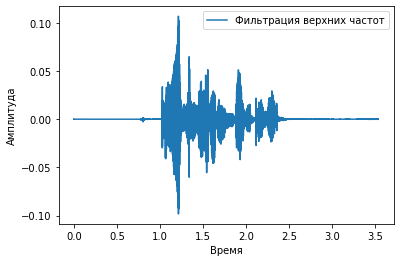

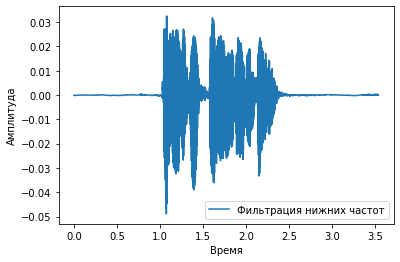

In [3]:
from scipy import signal
# выбираем значения частоты среза и порядок фильтра
Fs = 500
m = 1
wn = 2 * Fs / sf

# применяем фильтр верхних частот
b, a = signal.butter(m, wn, 'highpass')   # m указывает порядок фильтра

filtedData1 = signal.filtfilt(b, a, x)  #данные - это сигнал, который нужно отфильтровать

plt.plot(time, filtedData1, label="Фильтрация верхних частот")
plt.xlabel("Время")
plt.ylabel("Амплитуда")
plt.legend()
plt.show()

# применяем фильтр нижних частот
b, a = signal.butter(m, wn, 'lowpass')  

filtedData2 = signal.filtfilt(b, a, x)  

plt.plot(time, filtedData2, label="Фильтрация нижних частот")
plt.xlabel("Время")
plt.ylabel("Амплитуда")
plt.legend()
plt.show()


## **3. Детектор сигнал/шум**
Определяем среднее сигнала по амплитуде (без учета знака): 

$mid = \frac{1}{N}\sum_{k=0}^{N-1}|x(k)|$

Определяем порог детектора - $Th = \alpha*  mid$,  где 0 < $\alpha$ < 1  подбирается экспериментально. Задаем величину "провала"(в отсчетах) - $k$. Обозначим $y(i)$ - сигнал после детектирования.

* Событие "начало сигнала". Если $x(i)$ в течение $k$ отсчетов превышает порог, $y(i) = x(i)$.
* Событие "окончание сигнала". Если $x(i)$ в течение $k$ отсчетов меньше порога, $y(i) = 0$.

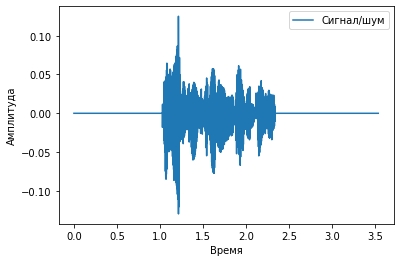

In [4]:
# определяем среднее сигнала по амплитуде
mid = 0   
for k in range(N):
  mid += abs(x[k])
mid = mid / N
alpha = 0.7
Th = alpha * mid # определяем порог детектора

k = 10
y2 = []
flag = False
count_t = 0
count_f = 0

for ind in range(N):
  if abs(x[ind]) > Th:
    count_t = count_t + 1
    count_f = 0
    if count_t >= k:
      flag = True
      y2.append(x[ind])
    else:
      y2.append(0)
  else:
    count_f = count_f + 1
    count_t = 0
    y2.append(0)
    if count_f >= k:
      flag = False

plt.plot(time, y2, label="Сигнал/шум")
plt.xlabel("Время")
plt.ylabel("Амплитуда")
plt.legend()
plt.show()

# **4. Эффект Эхо**
Ревербератор реализован, как набор линий задержки. Число линий задержки ${N_L >= 8}$.

Каждая линия задержки имеет свой весовой коэффициент (задается пользователем):  
  ${α_1>α_2>⋯>α_{N_L}}$ .

* Перед добавлением к исходному сигналу, выход ревербератора фильтруется ФНЧ-фильтром первого порядка.

* Желаемое соотношение между "сухим" и обработанным сигналом задается коэффициентом применимости ${\gamma}$.

* Ревербератор может работать в двух режимах: ручной и с использованием готовой конфигурации (preset):

Для ручного режима регулируется пользователем задается максимальная задержка ${D1}$, а величины остальных определяются автоматически через нее: ${D_i = D_1 * 2^{\frac{1 - i}{N_L}} , i = 2, . . . ,N_L}$.

Для готовой конфигурации пользователь вручную задает последовательность
${D_1>D_2>⋯>D_NL}$

В данной программе пользователь сначала выбирает режим: 1 - с использованием готовой конфигурации, 2 - ручной. Если пользователь ввел некорректный режим, то программа выдает повторный запрос на ввод режима и сообщение о неправильном выборе режима. Затем пользователь подает данные в соответствии с выбранным режимом.

Выберете режим: с использованием готовой конфигурации - 1 или ручной - 2
2
Введите максимальную задержку 50000


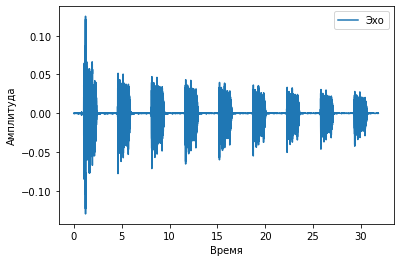

In [5]:
result = x
Di = []
flag = True
while(flag == True):
  print("Выберете режим: с использованием готовой конфигурации - 1 или ручной - 2")
  a = int(input())
  if (a == 1):
    for i in range(8):
      Di.append(int(input()))
    #сортируем и переворачиваем
    Di.sort()
    Di.reverse()
    flag = False
  elif (a == 2):
      D1 = int(input("Введите максимальную задержку "))
      Di.append(D1)
      flag = False
      for i in range(2, 9):
        D_next = D1 * 2 ** ((1 - i) / 8)
        Di.append(D_next)
  else:
    print("Введенный режим не верен, введите 1 или 2")
addArr = np.zeros(N * 8)
for i in range(len(Di)):
  xi = x * (Di[i] / sf)
  addArr[i * N : (i + 1) * N] = xi[:]
# выбираем значения частоты среза и порядок фильтра
Fs = 500
m = 1
wn = 2 * Fs / sf
g = 0.7
# применяем фильтр нижних частот
b, a = signal.butter(m, wn, 'lowpass')
filtedData3 = signal.filtfilt(b, a, addArr)
addArr = filtedData3 * g
result = [*result, *addArr]

plt.plot(np.linspace(0, (N/sf) * 9, N * 9), result, label="Эхо")
plt.xlabel("Время")
plt.ylabel("Амплитуда")
plt.legend()
plt.show()



# **5. Distortion**
Обозначим входной сигнал и выходной сигналы, соответственно как ${x(i)}$ и ${y(i), i = 0,1, . . . ,N - 1}$.

Пользователь задает порог — ${Th}$ и максимальное значение сигнала ${Max > Th}$.

Тогда ${Y(i) = \left\{\begin{matrix}
x(i), \left |x(i)\right| \leq Th
\\ 
Max \cdot sign(x(i)), |x(i)| &gt; T h
\end{matrix}\right.}$.



Зеленым цветом изображен исходный сигнал, синим - перегруженный.

Введите порог: 0.001
Введите максимальное значение сигнала: 0.1


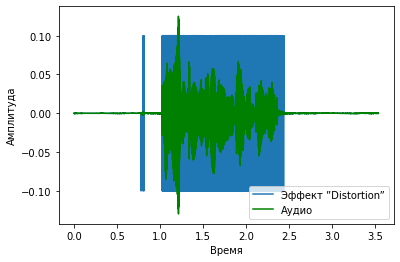

In [12]:
Th = float(input("Введите порог: "))
max = float(input("Введите максимальное значение сигнала: "))
y5 = []
for i in range(N):
    if (abs(x[i]) < Th):
        y5.append(x[i])
    else:
        y5.append(max * np.sign(x[i]))
plt.plot(time, y5, label="Эффект ”Distortion”")
plt.plot(time, x, label="Аудио", color = "green")
plt.xlabel("Время")
plt.ylabel("Амплитуда")
plt.legend()
plt.show()

# Вывод
В ходе выполнения лабораторной работы были изучены возможности библиотек Python для решения задач цифровой обработки сигналов